# Analiza atrybutów

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ndcg_score
import json
import seaborn as sns

In [3]:
DIR_DATA = 'data/v2'

In [4]:
artists = pd.read_json(path_or_buf=f'{DIR_DATA}/artists.jsonl', lines=True)
sessions = pd.read_json(path_or_buf=f'{DIR_DATA}/sessions.jsonl', lines=True)
tracks = pd.read_json(path_or_buf=f'{DIR_DATA}/tracks.jsonl', lines=True)
users = pd.read_json(path_or_buf=f'{DIR_DATA}/users.jsonl', lines=True)

### Przygotowanie danych do użycia 
- podział sesji według tygodni i utworów
- policzenie danych takich jak liczba odtworzeń, liczba polubień, przyrost odtworzeń, średni czas odtwarzania 

In [5]:
tracks = tracks.rename(columns={'id': 'track_id'})
tracks['release_date'] = pd.to_datetime(tracks['release_date'], errors='coerce')
tracks['release_date'] = tracks['release_date'].dt.year


merged_df = pd.merge(tracks[['track_id','duration_ms']], sessions, on='track_id', how='inner')
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
merged_df['week'] = merged_df['timestamp'].dt.strftime('%U')

start_date = pd.to_datetime('2022-12-05')

merged_df['week'] = (merged_df['timestamp'] - start_date).dt.days // 7
merged_df['week'] = merged_df['week'] + 1

#remove first and last week, because they're not complete
merged_df = merged_df[merged_df.week.isin([1, 53]) == False]
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1196511 entries, 0 to 1223971
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   track_id     1196511 non-null  object        
 1   duration_ms  1196511 non-null  int64         
 2   session_id   1196511 non-null  int64         
 3   timestamp    1196511 non-null  datetime64[ns]
 4   user_id      1196511 non-null  int64         
 5   event_type   1196511 non-null  object        
 6   week         1196511 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 73.0+ MB


Liczenie sumy wartości odtworzeń i polubień utworu w danym tygodniu

In [6]:
sessions_df = sessions
sessions_df['timestamp'] = pd.to_datetime(sessions_df['timestamp'])
sessions_df['week'] = sessions_df['timestamp'].dt.strftime('%U')

start_date = pd.to_datetime('2022-12-05')

sessions_df['week'] = (sessions_df['timestamp'] - start_date).dt.days // 7
sessions_df['week'] = sessions_df['week'] + 1


sessions_df = sessions_df[sessions_df.week.isin([1, 53]) == False]
all_weeks = sorted(sessions_df['week'].unique())
all_tracks = tracks['track_id'].unique()


df1 = pd.DataFrame({'track_id': all_tracks[:]})
df2 = pd.DataFrame({'week': all_weeks[:]})

empty_track_week_df = pd.merge(df1, df2, how='cross')

counts_df = sessions_df.groupby(['week', 'track_id'])['event_type'].value_counts().unstack(fill_value=0)
counts_df = counts_df.rename(columns={'play': 'play_count', 'like': 'like_count'}).reset_index()
counts_df = counts_df.drop(['skip'], axis=1)

tw_counts_df = pd.merge(empty_track_week_df, counts_df, on=['week', 'track_id'], how='left')
tw_counts_df = tw_counts_df.fillna(0)

print(tw_counts_df.tail)
tw_counts_df.info()


<bound method NDFrame.tail of                        track_id  week  like_count  play_count
0        0RNxWy0PC3AyH4ThH3aGK6     2         0.0         0.0
1        0RNxWy0PC3AyH4ThH3aGK6     3         0.0         0.0
2        0RNxWy0PC3AyH4ThH3aGK6     4         0.0         0.0
3        0RNxWy0PC3AyH4ThH3aGK6     5         0.0         0.0
4        0RNxWy0PC3AyH4ThH3aGK6     6         0.0         0.0
...                         ...   ...         ...         ...
1143007  27Y1N4Q4U3EfDU5Ubw8ws2    48         0.0         0.0
1143008  27Y1N4Q4U3EfDU5Ubw8ws2    49         1.0         1.0
1143009  27Y1N4Q4U3EfDU5Ubw8ws2    50         0.0         0.0
1143010  27Y1N4Q4U3EfDU5Ubw8ws2    51         0.0         0.0
1143011  27Y1N4Q4U3EfDU5Ubw8ws2    52         0.0         0.0

[1143012 rows x 4 columns]>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143012 entries, 0 to 1143011
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  

In [7]:
playtime_df = merged_df
playtime_df = playtime_df[playtime_df["event_type"] != "like"].copy()


grouped_df = playtime_df.groupby(['week', 'track_id', 'user_id'])
playtime_df['next_timestamp'] = grouped_df['timestamp'].shift(-1)
playtime_df['next_event_type'] = grouped_df['event_type'].shift(-1)


play_mask = (playtime_df['event_type'] == 'play') & (playtime_df['next_event_type'] == 'skip')
play_duration = (playtime_df['next_timestamp'] - playtime_df['timestamp']).dt.total_seconds() * 1000
track_duration = playtime_df['duration_ms']

playtime_df['playtime_ratio'] = 1
playtime_df.loc[play_mask, 'playtime_ratio'] = play_duration[play_mask] / track_duration[play_mask]


playtime_df = playtime_df.drop(['next_event_type', 'next_timestamp'], axis=1)
playtime_df = playtime_df[playtime_df["event_type"] != "skip"].reset_index()


grouped_playtime = playtime_df[playtime_df['event_type'] == 'play'].groupby(['track_id', 'week'])
mean_playtime = grouped_playtime['playtime_ratio'].mean().reset_index()

mean_playtime.info()
print(mean_playtime[mean_playtime["track_id"] == "27Y1N4Q4U3EfDU5Ubw8ws2"].sort_values(by="week"))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320345 entries, 0 to 320344
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   track_id        320345 non-null  object 
 1   week            320345 non-null  int64  
 2   playtime_ratio  320345 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 7.3+ MB
                     track_id  week  playtime_ratio
90634  27Y1N4Q4U3EfDU5Ubw8ws2     4        1.000000
90635  27Y1N4Q4U3EfDU5Ubw8ws2     5        1.000000
90636  27Y1N4Q4U3EfDU5Ubw8ws2     6        0.079125
90637  27Y1N4Q4U3EfDU5Ubw8ws2     8        0.678309
90638  27Y1N4Q4U3EfDU5Ubw8ws2    10        1.000000
90639  27Y1N4Q4U3EfDU5Ubw8ws2    11        1.000000
90640  27Y1N4Q4U3EfDU5Ubw8ws2    12        0.785934
90641  27Y1N4Q4U3EfDU5Ubw8ws2    13        1.000000
90642  27Y1N4Q4U3EfDU5Ubw8ws2    14        1.000000
90643  27Y1N4Q4U3EfDU5Ubw8ws2    16        1.000000
90644  27Y1N4Q4U3EfDU5Ubw8

Wyliczanie wartości słuchalnosći w danym tygodniu, oraz jej wartości historycznych w tygodniach poprzednich

In [8]:
all_counts_df = pd.merge(tw_counts_df, mean_playtime, on=['week', 'track_id'], how='left')
all_counts_df = all_counts_df.fillna(0)

listenability_df = all_counts_df.copy()
listenability_df['listenability'] = listenability_df['play_count'] * listenability_df['playtime_ratio'] + listenability_df['like_count']

listenability_df['lag_1'] = listenability_df.groupby('track_id')['listenability'].shift(1)
listenability_df['lag_2'] = listenability_df.groupby('track_id')['listenability'].shift(2)
listenability_df['lag_3'] = listenability_df.groupby('track_id')['listenability'].shift(3)

 
track_features = ['track_id', 'popularity', 'duration_ms', 'explicit', 'danceability', 
            'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo', 'release_date']


full_df = pd.merge(listenability_df, tracks[track_features], on=['track_id'], how='left')
counts_df = full_df
full_df = full_df.drop(['play_count', 'playtime_ratio', 'like_count'], axis=1)


full_df = full_df.fillna(0)
full_df.info()

print(full_df.tail)
#print(full_df[full_df["track_id"] == "27Y1N4Q4U3EfDU5Ubw8ws2"].sort_values(by="week"))



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143012 entries, 0 to 1143011
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   track_id          1143012 non-null  object 
 1   week              1143012 non-null  int64  
 2   listenability     1143012 non-null  float64
 3   lag_1             1143012 non-null  float64
 4   lag_2             1143012 non-null  float64
 5   lag_3             1143012 non-null  float64
 6   popularity        1143012 non-null  int64  
 7   duration_ms       1143012 non-null  int64  
 8   explicit          1143012 non-null  int64  
 9   danceability      1143012 non-null  float64
 10  energy            1143012 non-null  float64
 11  key               1143012 non-null  int64  
 12  loudness          1143012 non-null  float64
 13  speechiness       1143012 non-null  float64
 14  acousticness      1143012 non-null  float64
 15  instrumentalness  1143012 non-null  float64
 16  

## Rozkład słuchalności w danych

Po analizie wyników możemy zauważyć, że przytłaczająca większość rekordów ma zerową wartość słuchalności

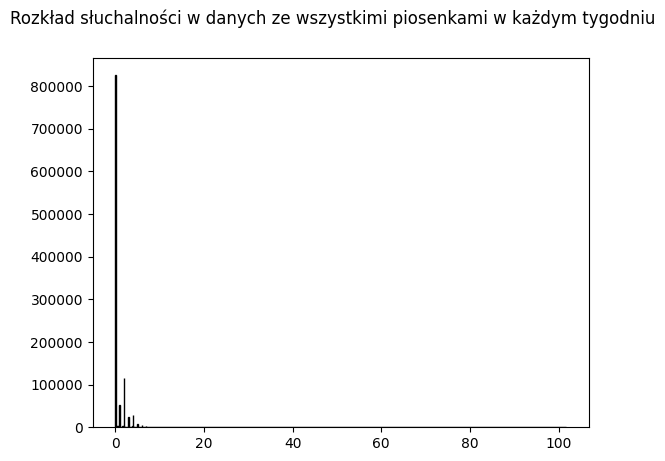

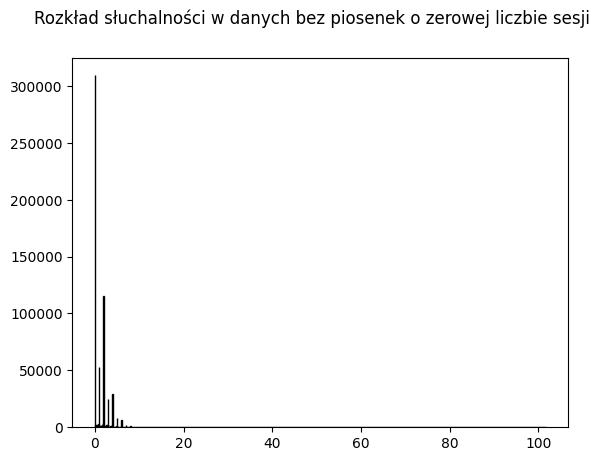

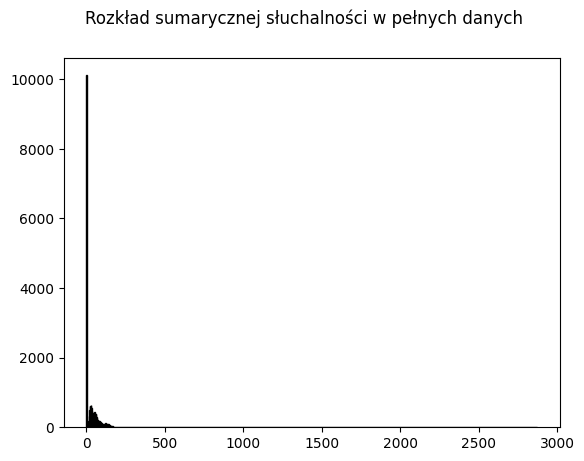

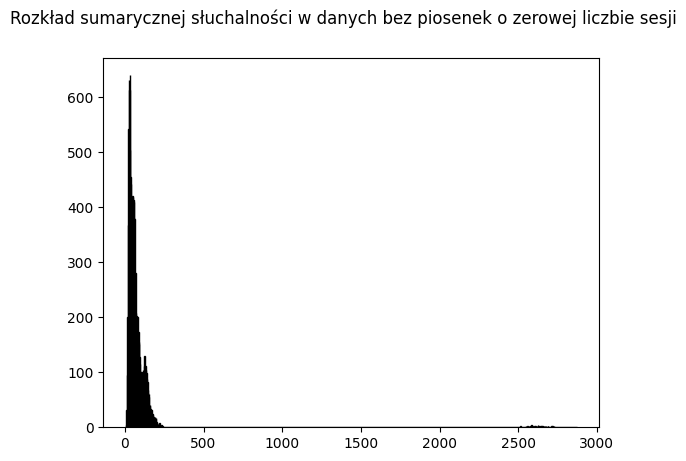

In [9]:
unique_tracks = sessions['track_id'].unique()
df_data2 = full_df[full_df['track_id'].isin(unique_tracks)]

df_data3 = full_df.groupby('track_id')['listenability'].sum().reset_index()
df_data3 = df_data3.merge(full_df.groupby('track_id').first().reset_index().drop(['listenability', 'week', 'lag_1', 'lag_2', 'lag_3'], axis=1), on='track_id', how='inner')
df_data4 = df_data3[df_data3['track_id'].isin(unique_tracks)]

data1 = full_df['listenability']
data2 = df_data2['listenability']
data3 = df_data3['listenability']
data4 = df_data4['listenability']

plt.hist(data1, bins=1000, edgecolor='black')
plt.suptitle('Rozkład słuchalności w danych ze wszystkimi piosenkami w każdym tygodniu')
plt.show()

plt.hist(data2, bins=1000, edgecolor='black')
plt.suptitle('Rozkład słuchalności w danych bez piosenek o zerowej liczbie sesji')
plt.show()

plt.hist(data3, bins=1000, edgecolor='black')
plt.suptitle('Rozkład sumarycznej słuchalności w pełnych danych')
plt.show()

plt.hist(data4, bins=1000, edgecolor='black')
plt.suptitle('Rozkład sumarycznej słuchalności w danych bez piosenek o zerowej liczbie sesji')
plt.show()

## Pandas ProfileReport - dla całego zbioru danych

In [10]:
# profile = ProfileReport(full_df, title="Pandas Profile Report - Full Data", html={'style':{'full_width':True}})
# Save your output file in html forma
# profile.to_file(output_file= "TS_report.html")

## Macierze korelacji

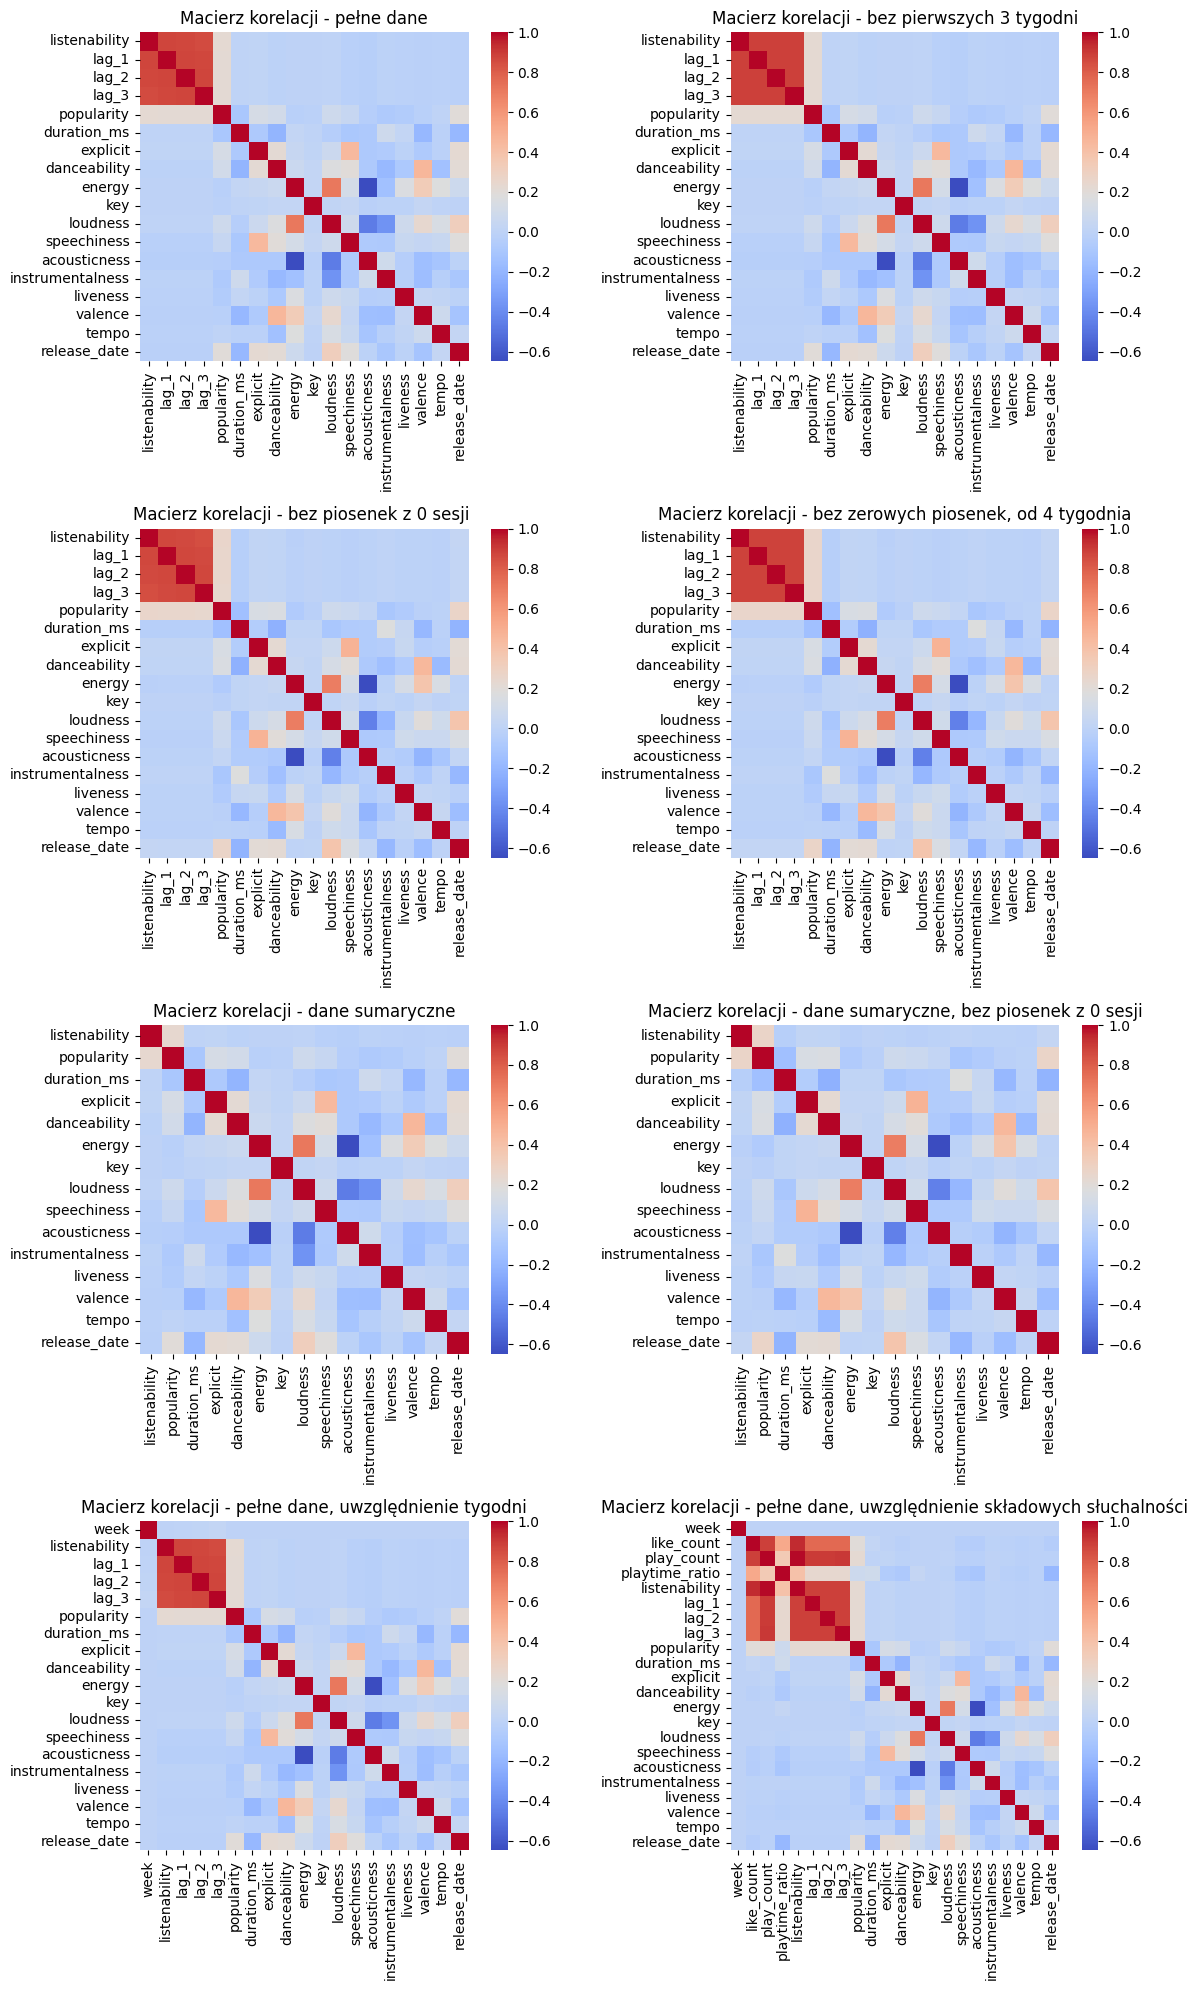

listenability    1.000000
lag_1            0.876305
lag_2            0.867515
lag_3            0.857085
popularity       0.221918
Name: listenability, dtype: float64
listenability    1.000000
lag_1            0.887257
lag_2            0.886180
lag_3            0.887072
popularity       0.221940
Name: listenability, dtype: float64
listenability    1.000000
lag_1            0.869986
lag_2            0.860832
lag_3            0.849979
popularity       0.254677
Name: listenability, dtype: float64
listenability    1.000000
lag_1            0.881430
lag_2            0.880289
lag_3            0.881240
popularity       0.254686
Name: listenability, dtype: float64
listenability    1.000000
popularity       0.235354
Name: listenability, dtype: float64
listenability    1.00000
popularity       0.27097
Name: listenability, dtype: float64
listenability    1.000000
lag_1            0.876305
lag_2            0.867515
lag_3            0.857085
popularity       0.221918
Name: listenability, dtype: floa

In [74]:
df1 = full_df                           # pełne dane
df2 = full_df[full_df['week'] > 4]      # bez pierwszych 3 tygodni (tak, żeby lag oznaczał rzeczywistą wartość)
df3 = df_data2                          # tylko dla tracków z sesjami
df4 = df_data2[df_data2['week'] > 4]    # bez pierwszych 3 tygodni (tak, żeby lag oznaczał rzeczywistą wartość), tylko dla tracków z sesjami
df5 = df_data3                          # z sumowaną wartością słuchalności
df6 = df_data4                          # z sumowaną wartością słuchalności, tylko dla tracków z sesjami


fig, axes = plt.subplots(4, 2, figsize=(12, 20))

# macierze korelacji dla różnych danych wejściowych
correlation_matrix1 = df1.drop(['track_id', 'week'], axis=1).corr()
correlation_matrix2 = df2.drop(['track_id', 'week'], axis=1).corr()
correlation_matrix3 = df3.drop(['track_id', 'week'], axis=1).corr()
correlation_matrix4 = df4.drop(['track_id', 'week'], axis=1).corr()
correlation_matrix5 = df5.drop(['track_id'], axis=1).corr()
correlation_matrix6 = df6.drop(['track_id'], axis=1).corr()
correlation_matrix7 = df1.drop(['track_id'], axis=1).corr()
correlation_matrix8 = counts_df.drop(['track_id'], axis=1).corr()

ax = sns.heatmap(correlation_matrix1, cmap='coolwarm', square=True,  ax=axes[0, 0])
axes[0, 0].set_title('Macierz korelacji - pełne dane')

ax = sns.heatmap(correlation_matrix2, cmap='coolwarm', square=True,  ax=axes[0, 1])
axes[0, 1].set_title('Macierz korelacji - bez pierwszych 3 tygodni')

ax = sns.heatmap(correlation_matrix3, cmap='coolwarm', square=True,  ax=axes[1, 0])
axes[1, 0].set_title('Macierz korelacji - bez piosenek z 0 sesji ')

ax = sns.heatmap(correlation_matrix4, cmap='coolwarm', square=True,  ax=axes[1, 1])
axes[1, 1].set_title('Macierz korelacji - bez zerowych piosenek, od 4 tygodnia')

ax = sns.heatmap(correlation_matrix5, cmap='coolwarm', square=True,  ax=axes[2, 0])
axes[2, 0].set_title('Macierz korelacji - dane sumaryczne')

ax = sns.heatmap(correlation_matrix6, cmap='coolwarm', square=True,  ax=axes[2, 1])
axes[2, 1].set_title('Macierz korelacji - dane sumaryczne, bez piosenek z 0 sesji')

ax = sns.heatmap(correlation_matrix7, cmap='coolwarm', square=True,  ax=axes[3, 0])
axes[3, 0].set_title('Macierz korelacji - pełne dane, uwzględnienie tygodni')

ax = sns.heatmap(correlation_matrix8, cmap='coolwarm', square=True,  ax=axes[3, 1])
axes[3, 1].set_title('Macierz korelacji - pełne dane, uwzględnienie składowych słuchalności')

plt.tight_layout()
plt.show()


# Wypis wartości korealcji elementów skorelowanych z słuchalnością co najmniej +/- 5%
print(correlation_matrix1[abs(correlation_matrix1['listenability']) > 0.05]['listenability']) 
print(correlation_matrix2[abs(correlation_matrix2['listenability']) > 0.05]['listenability']) 
print(correlation_matrix3[abs(correlation_matrix3['listenability']) > 0.05]['listenability']) 
print(correlation_matrix4[abs(correlation_matrix4['listenability']) > 0.05]['listenability'])
print(correlation_matrix5[abs(correlation_matrix5['listenability']) > 0.05]['listenability']) 
print(correlation_matrix6[abs(correlation_matrix6['listenability']) > 0.05]['listenability']) 
print(correlation_matrix7[abs(correlation_matrix7['listenability']) > 0.05]['listenability']) 
print(correlation_matrix8[abs(correlation_matrix8['listenability']) > 0.05]['listenability']) 

## Prosty model regresji dla przewidywania słuchalności każdego z utworów

In [73]:
# Jeden model dla wszystkich piosenek

features = ['lag_1', 'lag_2', 'lag_3']
target = ['listenability']
dataset = full_df

train_x = df4[df4['week'] <= 42][features]
train_y = df4[df4['week'] <= 42][target]
test_x = dataset[dataset['week'] > 42][features]
test_y = dataset[dataset['week'] > 42][['track_id', 'listenability']]


model = LinearRegression()
model.fit(train_x, train_y)

# Make predictions on the test set
test_y['predicted'] = model.predict(test_x)

# Calculate the Mean Squared Error on the test set
mse_test = mean_squared_error(test_y['listenability'], test_y['predicted'])
print(f"Mean Squared Error on Test Set: {mse_test}")

# Lista top20 utworów w tygodniu 44
test_y_44 = test_y.iloc[10::10]

top_20_real = test_y_44.nlargest(20, 'listenability')
top_20_preddicted = test_y_44.nlargest(20, 'predicted')
print(top_20_real)
print(top_20_preddicted)


Mean Squared Error on Test Set: 2.053954929334688
                      track_id  listenability  predicted
495557  4C6BlqqMwjFzOXzqpTeoWR      68.811719  51.258025
452819  0pqnGHJpmpxLKifKRmU6WP      66.131027  48.916519
466895  3ee8Jmje8o58CHK66QrVC2      64.104012  54.980636
494333  3YJJjQPAbDT7mGpX3WtQ9A      63.463288  56.573759
60527   0ofHAoxe9vBkTCp2UQIavz      62.054550  57.574489
506216  31qCy5ZaophVA81wtlwLc4      61.603871  60.859068
494843  5vGLcdRuSbUhD8ScwsGSdA      60.575517  47.813752
467048  2ZRo7axmMPeSVUvDbGkJah      60.236351  53.426711
495098  0E4Y1XIbs8GrAT1YqVy6dq      59.732466  56.088662
481685  2XU0oxnq2qxCpomAAuJY8K      59.617916  56.527723
438080  55Am8neGJkdj2ADaM3aw5H      59.394068  58.471402
481889  6Hj9jySrnFppAI0sEMCZpJ      59.305877  52.657497
494027  5QO79kh1waicV47BqGRL3g      58.515260  56.053994
505910  2TksvaRivgAEj780DgRB73      58.428503  48.067323
494384  35mvY5S1H3J2QZyna3TFe0      58.326035  55.599596
495149  1VLtjHwRWOVJiE5Py7JxoQ      58